# Prepare Pre-training Data for Semantic LLM

This notebook generates exhaustive training data for teaching an LLM to understand and work with semantic IDs.

In [ ]:
CATEGORY = "Video_Games"
SYSTEM_PROMPT = """
You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. 

Semantic IDs are hierarchical identifiers in the format <|sid_start|><|sid_0|><|sid_256|><|sid_512|><|sid_768|><|sid_end|> that encode product relationships and categories.
""".strip()

In [2]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
OUTPUT_DIR = DATA_DIR / "output" / "semantic_llm_training"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import polars as pl

from src.logger import setup_logger

logger = setup_logger("prep-pretraining-data")

## Load Data

In [4]:
# Load all required data
logger.info("Loading data files...")

items_df = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_items.parquet")
logger.info(f"Loaded {len(items_df):,} items with metadata")

semantic_ids_df = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_semantic_ids.parquet")
logger.info(f"Loaded {len(semantic_ids_df):,} semantic ID mappings")

sequences_df = pl.read_parquet(DATA_DIR / "output" / f"{CATEGORY}_sequences_with_semantic_ids.parquet")
logger.info(f"Loaded {len(sequences_df):,} user sequences")

# Join items with semantic IDs for easy access
df = items_df.join(semantic_ids_df, on="parent_asin")
logger.info(f"Joined data has {len(df):,} items with both metadata and semantic IDs")

09:18:29 - Loading data files...
09:18:29 - Loaded 66,133 items with metadata
09:18:29 - Loaded 66,133 semantic ID mappings
09:18:29 - Loaded 78,643 user sequences
09:18:29 - Joined data has 66,133 items with both metadata and semantic IDs


## Type A: SemanticID → Text Mappings

In [5]:
def generate_type_a_data_exhaustive(df):
    """Generate ALL SemanticID → Text mappings"""
    type_a_samples = []

    # For EVERY item, generate ALL variations
    for row in df.iter_rows(named=True):
        # Variation 1: ID to title
        type_a_samples.append(
            {"instruction": f"Product {row['semantic_id']} has title:", "output": row["title"], "type": "sid_to_title"}
        )

        # Variation 2: ID to description
        if row["description_text"] and len(row["description_text"]) > 50:
            type_a_samples.append(
                {
                    "instruction": f"Item {row['semantic_id']} is described as:",
                    "output": row["description_text"],
                    "type": "sid_to_description",
                }
            )

        # Variation 3: ID to category
        if row["categories_text"]:
            type_a_samples.append(
                {
                    "instruction": f"Product {row['semantic_id']} belongs to category:",
                    "output": row["categories_text"],
                    "type": "sid_to_category",
                }
            )

        # Variation 4: ID to full context
        type_a_samples.append(
            {
                "instruction": f"Tell me about product {row['semantic_id']}:",
                "output": f"Title: {row['title']} Description: {row['description_text']} Category: {row['main_category']}",
                "type": "sid_to_context",
            }
        )

        # Variation 5: ID to features
        if row["features_text"] and len(row["features_text"]) > 20:
            type_a_samples.append(
                {
                    "instruction": f"Product {row['semantic_id']} features:",
                    "output": row["features_text"],
                    "type": "sid_to_features",
                }
            )

    logger.info(f"Generated {len(type_a_samples):,} Type A samples from {len(df):,} items")
    return type_a_samples


# Generate Type A data
type_a_samples = generate_type_a_data_exhaustive(df)
logger.info(f"Type A samples: {len(type_a_samples):,}")

09:18:29 - Generated 318,759 Type A samples from 66,133 items
09:18:29 - Type A samples: 318,759


In [6]:
# Sample 3 examples from type A data
logger.info("\nType A samples (SemanticID → Text):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_a_df = pl.DataFrame(type_a_samples)
for type_name in type_a_df["type"].unique().sort():
    samples = type_a_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_a_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:29 - 
Type A samples (SemanticID → Text):
09:18:29 - ================================================================================
09:18:29 - sid_to_category:
09:18:29 - 
09:18:29 -   IN:  Product <sid><SID_62><SID_409><SID_590><SID_768></sid> belongs to category:
09:18:29 -   OUT: Video Games > PC > Games
09:18:29 - 
09:18:29 -   IN:  Product <sid><SID_29><SID_468><SID_699><SID_768></sid> belongs to category:
09:18:29 -   OUT: Video Games > Xbox One > Accessories > Accessory Kits
09:18:29 - 
09:18:29 -   IN:  Product <sid><SID_102><SID_378><SID_604><SID_768></sid> belongs to category:
09:18:29 -   OUT: Video Games > Video Games Accessories
09:18:29 - 
09:18:29 - --------------------------------------------------------------------------------
09:18:29 - sid_to_context:
09:18:29 - 
09:18:29 -   IN:  Tell me about product <sid><SID_44><SID_305><SID_715><SID_768></sid>:
09:18:29 -   OUT: Title: Siomeoar Ps4 Controller Compatible with Ps4 Console Ps4 Pro Ps4 Games PC with Advanced

## Type B: Text → SemanticID Mappings

In [7]:
def generate_type_b_data_exhaustive(df):
    """Generate ALL Text → SemanticID mappings"""
    type_b_samples = []

    for row in df.iter_rows(named=True):
        # Variation 1: Full title to ID
        type_b_samples.append(
            {
                "instruction": f'The product "{row["title"]}" has SemanticID:',
                "output": row["semantic_id"],
                "type": "title_to_sid",
            }
        )

        # Variation 2: Title substring to ID (multiple substrings)
        title_words = row["title"].split()
        if len(title_words) >= 3:
            # Beginning of title
            type_b_samples.append(
                {
                    "instruction": f'A product titled "{" ".join(title_words)}" has SemanticID:',
                    "output": row["semantic_id"],
                    "type": "title_prefix_to_sid",
                }
            )

        # Variation 2b: Title containing words
        if len(title_words) > 6:
            mid_start = len(title_words) // 2 - 2
            mid_end = min(mid_start + 4, len(title_words))
            type_b_samples.append(
                {
                    "instruction": f'A product with "...{" ".join(title_words[mid_start:mid_end])}..." in its title has SemanticID:',
                    "output": row["semantic_id"],
                    "type": "title_contains_to_sid",
                }
            )

        # Variation 3: Description snippets (multiple)
        if row["description_text"] and len(row["description_text"]) > 250:
            # First 250 chars
            type_b_samples.append(
                {
                    "instruction": f'A product described as "{row["description_text"][:250]}..." has SemanticID:',
                    "output": row["semantic_id"],
                    "type": "description_to_sid",
                }
            )

        # Variation 3b: Description containing words
        for i in [50, 100, 200]:
            if row["description_text"] and len(row["description_text"]) > i + 50:
                snippet = row["description_text"][i : i + 50]
                if len(snippet.strip()) > 10:  # Ensure meaningful snippet
                    type_b_samples.append(
                        {
                            "instruction": f'A product with description containing "...{snippet}..." has SemanticID:',
                            "output": row["semantic_id"],
                            "type": "description_contains_to_sid",
                        }
                    )

        # Variation 4: Category + features to ID
        if row["features_text"] and len(row["features_text"]) > 20:
            type_b_samples.append(
                {
                    "instruction": f'A {row["main_category"]} product with features "{row["features_text"]}" has SemanticID:',
                    "output": row["semantic_id"],
                    "type": "features_to_sid",
                }
            )

    logger.info(f"Generated {len(type_b_samples):,} Type B samples from {len(df):,} items")
    return type_b_samples


# Generate Type B data
type_b_samples = generate_type_b_data_exhaustive(df)
logger.info(f"Type B samples: {len(type_b_samples):,}")

09:18:29 - Generated 478,544 Type B samples from 66,133 items
09:18:29 - Type B samples: 478,544


In [8]:
# Sample 3 examples from type B data
logger.info("\nType B samples (Text → SemanticID):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_b_df = pl.DataFrame(type_b_samples)
for type_name in type_b_df["type"].unique().sort():
    samples = type_b_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_b_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:29 - 
Type B samples (Text → SemanticID):
09:18:29 - ================================================================================
09:18:30 - description_contains_to_sid:
09:18:30 - 
09:18:30 -   IN:  A product with description containing "...nia, a land frozen in a 100 year winter by the evi..." has SemanticID:
09:18:30 -   OUT: <sid><SID_143><SID_379><SID_730><SID_768></sid>
09:18:30 - 
09:18:30 -   IN:  A product with description containing "...on the role of the savage Killer, and the other fo..." has SemanticID:
09:18:30 -   OUT: <sid><SID_137><SID_282><SID_600><SID_768></sid>
09:18:30 - 
09:18:30 -   IN:  A product with description containing "...ng pot Increases the number of dishes you can cook..." has SemanticID:
09:18:30 -   OUT: <sid><SID_248><SID_393><SID_654><SID_768></sid>
09:18:30 - 
09:18:30 - --------------------------------------------------------------------------------
09:18:30 - description_to_sid:
09:18:30 - 
09:18:30 -   IN:  A product described as "Take

## Type C: User Sequence Prediction

In [9]:
def generate_type_c_data_exhaustive(sequences_df):
    """Generate ALL possible sequence predictions"""
    type_c_samples = []

    # Process every sequence
    for row in sequences_df.iter_rows(named=True):
        seq = row["semantic_id_sequence"]

        # Generate predictions for EVERY valid split point
        for split_point in range(2, len(seq)):  # Need at least 2 items in history
            history = seq[:split_point]
            target = seq[split_point]

            # Variation 1: Last 3 items only (if enough history)
            if len(history) >= 3:
                type_c_samples.append(
                    {
                        "instruction": f"Based on recent purchases: {', '.join(history[-3:])}, next item:",
                        "output": target,
                        "type": "seq_last_3",
                    }
                )

            # Variation 2: Last 5 items (if enough history)
            if len(history) >= 5:
                type_c_samples.append(
                    {
                        "instruction": f"Purchase sequence: {', '.join(history[-5:])}. Predict next:",
                        "output": target,
                        "type": "seq_last_5",
                    }
                )

            # Variation 3: Last 2 items (always possible)
            type_c_samples.append(
                {
                    "instruction": f"User's last purchases: {', '.join(history[-2:])}. Next:",
                    "output": target,
                    "type": "seq_last_2",
                }
            )

    logger.info(f"Generated {len(type_c_samples):,} Type C samples from {len(sequences_df):,} sequences")
    return type_c_samples


# Generate Type C data
type_c_samples = generate_type_c_data_exhaustive(sequences_df)
logger.info(f"Type C samples: {len(type_c_samples):,}")

09:18:30 - Generated 800,881 Type C samples from 78,643 sequences
09:18:30 - Type C samples: 800,881


In [10]:
# Sample 3 examples from type C data
logger.info("\nType C samples (Sequence Prediction):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_c_df = pl.DataFrame(type_c_samples)
for type_name in type_c_df["type"].unique().sort():
    samples = type_c_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_c_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:30 - 
Type C samples (Sequence Prediction):
09:18:30 - ================================================================================
09:18:30 - seq_last_2:
09:18:30 - 
09:18:30 -   IN:  User's last purchases: <sid><SID_15><SID_280><SID_730><SID_768></sid>, <sid><SID_220><SID_355><SID_758><SID_769></sid>. Next:
09:18:30 -   OUT: <sid><SID_3><SID_264><SID_667><SID_768></sid>
09:18:30 - 
09:18:30 -   IN:  User's last purchases: <sid><SID_115><SID_342><SID_607><SID_768></sid>, <sid><SID_246><SID_412><SID_722><SID_768></sid>. Next:
09:18:30 -   OUT: <sid><SID_112><SID_356><SID_611><SID_768></sid>
09:18:30 - 
09:18:30 -   IN:  User's last purchases: <sid><SID_211><SID_315><SID_539><SID_768></sid>, <sid><SID_15><SID_406><SID_526><SID_769></sid>. Next:
09:18:30 -   OUT: <sid><SID_152><SID_490><SID_611><SID_768></sid>
09:18:30 - 
09:18:30 - --------------------------------------------------------------------------------
09:18:30 - seq_last_3:
09:18:30 - 
09:18:30 -   IN:  Based on rece

## Type D: Category/Semantic Understanding

In [11]:
def generate_type_d_data_exhaustive(df):
    """Generate ALL semantic understanding patterns"""
    type_d_samples = []

    # Pattern 1: Level 0 prefix understanding (all prefixes)
    prefix_0_groups = df.group_by("semantic_id_0").agg(
        [
            pl.col("main_category").mode().first().alias("common_category"),
            pl.col("main_category").n_unique().alias("n_categories"),
            pl.col("semantic_id").alias("example_ids"),
            pl.len().alias("count"),
        ]
    )

    for row in prefix_0_groups.iter_rows(named=True):
        if row["count"] >= 5:  # Only for prefixes with enough examples
            type_d_samples.append(
                {
                    "instruction": f"Products starting with <sid><SID_{row['semantic_id_0']}> are typically:",
                    "output": f"{row['common_category']} products",
                    "type": "prefix_category",
                }
            )

            # Add examples
            example_ids = row["example_ids"][:3]
            type_d_samples.append(
                {
                    "instruction": f"Examples of products with prefix <sid><SID_{row['semantic_id_0']}>:",
                    "output": ", ".join(example_ids),
                    "type": "prefix_examples",
                }
            )

    # Pattern 2: Level 0+1 prefix understanding
    prefix_01_groups = df.group_by(["semantic_id_0", "semantic_id_1"]).agg(
        [
            pl.col("main_category").mode().first().alias("common_category"),
            pl.col("semantic_id").alias("example_ids"),
            pl.len().alias("count"),
        ]
    )

    for row in prefix_01_groups.iter_rows(named=True):
        if row["count"] >= 3:
            prefix = f"<sid><SID_{row['semantic_id_0']}><SID_{256 + row['semantic_id_1']}>"
            type_d_samples.append(
                {
                    "instruction": f"Products starting with {prefix} are:",
                    "output": f"{row['common_category']} items",
                    "type": "prefix_2level_category",
                }
            )

    # Pattern 3: Find ALL similar items (same first 2 codes)
    similar_groups = df.group_by(["semantic_id_0", "semantic_id_1"]).agg(
        [pl.col("semantic_id").alias("similar_ids"), pl.col("title").alias("similar_titles"), pl.len().alias("count")]
    )

    for row in similar_groups.iter_rows(named=True):
        if row["count"] > 1:  # Has similar items
            ids = row["similar_ids"]
            for i, base_id in enumerate(ids):
                other_ids = [id for j, id in enumerate(ids) if j != i]
                if other_ids:
                    type_d_samples.append(
                        {
                            "instruction": f"Products similar to {base_id} include:",
                            "output": ", ".join(other_ids[:5]),  # Limit to 5
                            "type": "similar_products",
                        }
                    )

    logger.info(f"Generated {len(type_d_samples):,} Type D samples")
    return type_d_samples


# Generate Type D data
type_d_samples = generate_type_d_data_exhaustive(df)
logger.info(f"Type D samples: {len(type_d_samples):,}")

09:18:30 - Generated 63,116 Type D samples
09:18:30 - Type D samples: 63,116


In [12]:
# Sample 3 examples from type D data
logger.info("\nType D samples (Semantic Understanding):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_d_df = pl.DataFrame(type_d_samples)
for type_name in type_d_df["type"].unique().sort():
    samples = type_d_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_d_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:30 - 
Type D samples (Semantic Understanding):
09:18:30 - ================================================================================
09:18:30 - prefix_2level_category:
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_225><SID_431> are:
09:18:30 -   OUT: Computers items
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_188><SID_315> are:
09:18:30 -   OUT: Amazon Home items
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_52><SID_309> are:
09:18:30 -   OUT: Video Games items
09:18:30 - 
09:18:30 - --------------------------------------------------------------------------------
09:18:30 - prefix_category:
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_249> are typically:
09:18:30 -   OUT: Video Games products
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_192> are typically:
09:18:30 -   OUT: Video Games products
09:18:30 - 
09:18:30 -   IN:  Products starting with <sid><SID_43> are typically:
09:18:30 - 

## Type E: Multi-hop Reasoning

In [13]:
def generate_type_e_data_exhaustive(df, sequences_df):
    """Generate ALL multi-hop reasoning patterns"""
    type_e_samples = []

    # Create lookup dictionaries for efficiency
    semantic_to_info = {
        row["semantic_id"]: {
            "title": row["title"],
            "category": row["main_category"],
            "store": row["store"],
            "asin": row["parent_asin"],
        }
        for row in df.iter_rows(named=True)
    }

    # Also need ASIN to semantic ID mapping
    asin_to_semantic = {row["parent_asin"]: row["semantic_id"] for row in df.iter_rows(named=True)}

    # Pattern 1: Co-purchase patterns from sequences
    logger.info("Generating co-purchase patterns...")
    for idx, row in enumerate(sequences_df.iter_rows(named=True)):
        if idx % 10000 == 0:
            logger.info(f"  Processing sequence {idx:,} / {len(sequences_df):,}")

        seq = row["semantic_id_sequence"]
        if len(seq) >= 2:
            # For every pair in the sequence
            for i in range(len(seq) - 1):
                for j in range(i + 1, min(i + 5, len(seq))):  # Look ahead up to 5 items
                    item1, item2 = seq[i], seq[j]
                    if item1 in semantic_to_info:
                        info1 = semantic_to_info[item1]
                        type_e_samples.append(
                            {
                                "instruction": f"A user who bought {item1} ({info1['title']}) might also buy:",
                                "output": item2,
                                "type": "copurchase_forward",
                            }
                        )

                        # Reverse direction
                        if item2 in semantic_to_info:
                            info2 = semantic_to_info[item2]
                            type_e_samples.append(
                                {
                                    "instruction": f"Before buying {item2} ({info2['title']}), users often buy:",
                                    "output": item1,
                                    "type": "copurchase_backward",
                                }
                            )

    # Pattern 2: Category transition patterns
    logger.info("Generating category transition patterns...")
    category_transitions = []
    for row in sequences_df.iter_rows(named=True):
        # Get categories for each item in sequence
        categories = []
        for asin in row["sequence"]:
            if asin in asin_to_semantic and asin_to_semantic[asin] in semantic_to_info:
                categories.append(semantic_to_info[asin_to_semantic[asin]]["category"])

        # Record all transitions
        for i in range(len(categories) - 1):
            category_transitions.append((categories[i], categories[i + 1]))

    # Count transitions
    transition_counts = Counter(category_transitions)

    # Generate patterns for common transitions
    for (cat1, cat2), count in transition_counts.items():
        if count >= 5:  # Common transitions
            type_e_samples.append(
                {
                    "instruction": f"After buying from {cat1}, users often buy from:",
                    "output": cat2,
                    "type": "category_transition",
                }
            )

    logger.info(f"Generated {len(type_e_samples):,} Type E samples")
    return type_e_samples


# Generate Type E data
type_e_samples = generate_type_e_data_exhaustive(df, sequences_df)
logger.info(f"Type E samples: {len(type_e_samples):,}")

09:18:30 - Generating co-purchase patterns...
09:18:30 -   Processing sequence 0 / 78,643
09:18:31 -   Processing sequence 10,000 / 78,643
09:18:31 -   Processing sequence 20,000 / 78,643
09:18:31 -   Processing sequence 30,000 / 78,643
09:18:31 -   Processing sequence 40,000 / 78,643
09:18:31 -   Processing sequence 50,000 / 78,643
09:18:31 -   Processing sequence 60,000 / 78,643
09:18:31 -   Processing sequence 70,000 / 78,643
09:18:31 - Generating category transition patterns...
09:18:31 - Generated 2,569,685 Type E samples
09:18:31 - Type E samples: 2,569,685


In [14]:
# Sample 3 examples from type E data
logger.info("\nType E samples (Multi-hop Reasoning):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_e_df = pl.DataFrame(type_e_samples)
for type_name in type_e_df["type"].unique().sort():
    samples = type_e_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_e_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:31 - 
Type E samples (Multi-hop Reasoning):
09:18:31 - ================================================================================
09:18:32 - category_transition:
09:18:32 - 
09:18:32 -   IN:  After buying from Toys & Games, users often buy from:
09:18:32 -   OUT: Toys & Games
09:18:32 - 
09:18:32 -   IN:  After buying from Toys & Games, users often buy from:
09:18:32 -   OUT: Video Games
09:18:32 - 
09:18:32 -   IN:  After buying from , users often buy from:
09:18:32 -   OUT: Software
09:18:32 - 
09:18:32 - --------------------------------------------------------------------------------
09:18:32 - copurchase_backward:
09:18:32 - 
09:18:32 -   IN:  Before buying <sid><SID_95><SID_490><SID_635><SID_768></sid> (Xbox One S 500GB Console - Minecraft Bundle [Discontinued]), users often buy:
09:18:32 -   OUT: <sid><SID_176><SID_459><SID_739><SID_768></sid>
09:18:32 - 
09:18:32 -   IN:  Before buying <sid><SID_232><SID_446><SID_756><SID_768></sid> (Pac-Man and the Ghostly Adventure

## Additional Pattern Generation

In [15]:
def generate_additional_patterns_exhaustive(df, sequences_df):
    """Generate additional training patterns"""
    additional_samples = []

    # Pattern: Sequence length understanding
    for length in [3, 5, 10, 20]:
        long_sequences = sequences_df.filter(pl.col("semantic_id_sequence_length") >= length)
        if len(long_sequences) > 0:
            # Get multiple examples for each length
            for i in range(min(10, len(long_sequences))):
                sample_seq = long_sequences.row(i, named=True)["semantic_id_sequence"]
                additional_samples.append(
                    {
                        "instruction": f"Example of a {length}+ item purchase sequence:",
                        "output": ", ".join(sample_seq[:length]),
                        "type": "sequence_length_example",
                    }
                )

    # Pattern: Popular item combinations
    # Find items that appear together frequently
    item_pairs = Counter()
    for row in sequences_df.iter_rows(named=True):
        seq = row["semantic_id_sequence"]
        for i in range(len(seq) - 1):
            for j in range(i + 1, min(i + 3, len(seq))):
                pair = tuple(sorted([seq[i], seq[j]]))
                item_pairs[pair] += 1

    # Generate samples for frequent pairs
    for (item1, item2), count in item_pairs.most_common(500):
        if count >= 3:
            additional_samples.append(
                {
                    "instruction": f"Items frequently bought together: {item1} and:",
                    "output": item2,
                    "type": "frequently_bought_together",
                }
            )

    logger.info(f"Generated {len(additional_samples):,} additional samples")
    return additional_samples


# Generate additional patterns
type_f_samples = generate_additional_patterns_exhaustive(df, sequences_df)
logger.info(f"Additional samples: {len(type_f_samples):,}")

09:18:33 - Generated 540 additional samples
09:18:33 - Additional samples: 540


In [16]:
# Sample 3 examples from additional patterns (Type F)
logger.info("Type F samples (Additional Patterns):")
logger.info("=" * 80)

# Convert to DataFrame for easier sampling by type
type_f_df = pl.DataFrame(type_f_samples)
for type_name in type_f_df["type"].unique().sort():
    samples = type_f_df.filter(pl.col("type") == type_name).sample(
        n=min(3, type_f_df.filter(pl.col("type") == type_name).height)
    )
    logger.info(f"{type_name}:")
    logger.info("")
    for row in samples.iter_rows(named=True):
        logger.info(f"  IN:  {row['instruction']}")
        logger.info(f"  OUT: {row['output']}")
        logger.info("")
    logger.info("-" * 80)

09:18:33 - Type F samples (Additional Patterns):
09:18:33 - ================================================================================
09:18:33 - frequently_bought_together:
09:18:33 - 
09:18:33 -   IN:  Items frequently bought together: <sid><SID_246><SID_412><SID_722><SID_768></sid> and:
09:18:33 -   OUT: <sid><SID_51><SID_474><SID_637><SID_768></sid>
09:18:33 - 
09:18:33 -   IN:  Items frequently bought together: <sid><SID_48><SID_291><SID_547><SID_768></sid> and:
09:18:33 -   OUT: <sid><SID_48><SID_354><SID_734><SID_768></sid>
09:18:33 - 
09:18:33 -   IN:  Items frequently bought together: <sid><SID_24><SID_418><SID_712><SID_770></sid> and:
09:18:33 -   OUT: <sid><SID_8><SID_470><SID_653><SID_768></sid>
09:18:33 - 
09:18:33 - --------------------------------------------------------------------------------
09:18:33 - sequence_length_example:
09:18:33 - 
09:18:33 -   IN:  Example of a 10+ item purchase sequence:
09:18:33 -   OUT: <sid><SID_84><SID_462><SID_655><SID_768></sid>, 

## Data Validation and Quality Checks

In [17]:
def validate_semantic_id_format(sid):
    """Ensure semantic ID follows correct format"""
    pattern = r"^<sid>(<SID_\d+>){4}</sid>$"
    return bool(re.match(pattern, sid))


def validate_training_data(samples, sample_size=1000):
    """Check data quality on a sample"""
    issues = []

    # Sample for validation
    to_validate = samples[: min(sample_size, len(samples))]

    for i, sample in enumerate(to_validate):
        # Check semantic ID format in output
        if "<sid>" in sample["output"]:
            # Extract all semantic IDs from output
            sid_pattern = r"<sid>(?:<SID_\d+>){4}</sid>"
            sids = re.findall(sid_pattern, sample["output"])
            for sid in sids:
                if not validate_semantic_id_format(sid):
                    issues.append(f"Sample {i}: Invalid semantic ID format: {sid}")

        # Check for empty fields
        if not sample["instruction"] or not sample["output"]:
            issues.append(f"Sample {i}: Empty instruction or output")

        # Check for overly long fields
        if len(sample["instruction"]) > 1000:
            issues.append(f"Sample {i}: Instruction too long ({len(sample['instruction'])} chars)")
        if len(sample["output"]) > 2000:
            issues.append(f"Sample {i}: Output too long ({len(sample['output'])} chars)")

    return issues


# Validate a sample of data
logger.info("Validating data quality...")
all_current_samples = (
    type_a_samples + type_b_samples + type_c_samples + type_d_samples + type_e_samples + type_f_samples
)
validation_issues = validate_training_data(all_current_samples)

if validation_issues:
    logger.warning(f"Found {len(validation_issues)} validation issues:")
    for issue in validation_issues[:10]:  # Show first 10 issues
        logger.warning(f"  {issue}")
    if len(validation_issues) > 10:
        logger.warning(f"  ... and {len(validation_issues) - 10} more issues")
else:
    logger.info("✓ Data validation passed!")

09:18:33 - Validating data quality...
09:18:33 - Found 63 validation issues:
09:18:33 -   Sample 36: Output too long (2124 chars)
09:18:33 -   Sample 38: Output too long (2206 chars)
09:18:33 -   Sample 46: Output too long (4014 chars)
09:18:33 -   Sample 48: Output too long (4107 chars)
09:18:33 -   Sample 90: Output too long (7507 chars)
09:18:33 -   Sample 92: Output too long (7577 chars)
09:18:33 -   Sample 95: Output too long (3615 chars)
09:18:33 -   Sample 97: Output too long (3714 chars)
09:18:33 -   Sample 112: Output too long (2154 chars)
09:18:33 -   Sample 119: Output too long (2217 chars)
09:18:33 -   ... and 53 more issues


## Combine and Prepare Final Dataset

In [18]:
all_samples = type_a_samples + type_b_samples + type_c_samples + type_d_samples + type_e_samples + type_f_samples
logger.info(f"Total samples before deduplication: {len(all_samples):,}")

09:18:33 - Total samples before deduplication: 4,231,525


In [19]:
def convert_to_conversation_format(samples):
    """Convert instruction/output format to conversation format for fine-tuning"""
    conversations_data = []

    for sample in samples:
        conversation = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": sample["instruction"]},
            {"role": "assistant", "content": sample["output"]},
        ]

        conversations_data.append(
            {
                "conversations": conversation,
                "type": sample.get("type", "unknown"),  # Keep type for analysis
            }
        )

    return conversations_data


logger.info("Defined conversation format converter")

09:18:33 - Defined conversation format converter


In [20]:
# Convert all samples to conversation format
logger.info("Converting samples to conversation format...")
conversations_data = convert_to_conversation_format(all_samples)
logger.info(f"Converted {len(conversations_data):,} samples to conversation format")

# Show a sample conversation
logger.info("\nSample conversation:")
sample_conv = conversations_data[0]
logger.info(f"Type: {sample_conv['type']}")
for turn in sample_conv["conversations"]:
    role = turn["role"]
    content = turn["content"]
    # Truncate long content for display
    if len(content) > 150:
        content = content[:150] + "..."
    logger.info(f"  {role}: {content}")

09:18:33 - Converting samples to conversation format...
09:18:40 - Converted 4,231,525 samples to conversation format
09:18:40 - 
Sample conversation:
09:18:40 - Type: sid_to_title
09:18:40 -   system: You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. 

Semantic IDs are hierarchical identifiers i...
09:18:40 -   user: Product <sid><SID_12><SID_311><SID_564><SID_768></sid> has title:
09:18:40 -   assistant: Dash 8-300 Professional Add-On


In [21]:
# Create DataFrame with conversations
df_samples = pl.DataFrame(conversations_data)

# Add analysis columns based on the conversation content
df_samples = df_samples.with_columns(
    [
        # Extract user message (instruction) and assistant message (output) for analysis
        pl.col("conversations").list.get(1).struct.field("content").alias("user_message"),
        pl.col("conversations").list.get(2).struct.field("content").alias("assistant_message"),
    ]
)

# Add length analysis
df_samples = df_samples.with_columns(
    [
        pl.col("user_message").str.len_chars().alias("user_message_length"),
        pl.col("assistant_message").str.len_chars().alias("assistant_message_length"),
        pl.col("user_message").str.split(" ").list.len().alias("user_message_tokens"),
        pl.col("assistant_message").str.split(" ").list.len().alias("assistant_message_tokens"),
    ]
)

logger.info(f"\nCreated DataFrame with {len(df_samples):,} samples")
logger.info(f"Columns: {df_samples.columns}")

# Show sample of the DataFrame (without the full conversations column for readability)
df_samples.select(
    [
        "type",
        "conversations",
        "user_message_length",
        "assistant_message_length",
        "user_message_tokens",
        "assistant_message_tokens",
    ]
).head(3)

09:18:53 - 
Created DataFrame with 4,231,525 samples
09:18:53 - Columns: ['conversations', 'type', 'user_message', 'assistant_message', 'user_message_length', 'assistant_message_length', 'user_message_tokens', 'assistant_message_tokens']


type,conversations,user_message_length,assistant_message_length,user_message_tokens,assistant_message_tokens
str,list[struct[2]],u32,u32,u32,u32
"""sid_to_title""","[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Product <sid><SID_12><SID_311><SID_564><SID_768></sid> has title:""}, {""assistant"",""Dash 8-300 Professional Add-On""}]",65,30,4,4
"""sid_to_description""","[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Item <sid><SID_12><SID_311><SID_564><SID_768></sid> is described as:""}, {""assistant"",""The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flights and utilities together in one fantastic package.""}]",68,507,5,80
"""sid_to_category""","[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Product <sid><SID_12><SID_311><SID_564><SID_768></sid> belongs to category:""}, {""assistant"",""Video Games > PC > Games""}]",75,24,5,6


In [22]:
# # Deduplicate based on instruction-output pairs (DON'T DEDUPLICATE FOR DATA DIVERSITY)
# unique_samples = {}
# for sample in all_samples:
#     key = (sample["instruction"], sample["output"])
#     if key not in unique_samples:
#         unique_samples[key] = sample

# all_samples = list(unique_samples.values())
# logger.info(f"Total samples after deduplication: {len(all_samples):,}")
# logger.info(
#     f"Removed {len(type_a_samples + type_b_samples + type_c_samples + type_d_samples + type_e_samples + type_f_samples) - len(all_samples):,} duplicate samples"
# )

In [23]:
# Shuffle and split data
logger.info("Shuffling data...")
df_samples = df_samples.sample(fraction=1.0, shuffle=True, seed=42)

# Split into train/val/test
train_size = int(0.95 * len(df_samples))
val_size = int(0.05 * len(df_samples))

train_df = df_samples[:train_size]
val_df = df_samples[train_size : train_size + val_size]

logger.info("Dataset splits:")
logger.info(f"  Train: {len(train_df):,} samples")
logger.info(f"  Val: {len(val_df):,} samples")

# Select only the essential columns for fine-tuning (conversations and optionally type for filtering)
train_df_final = train_df.select(["conversations", "type"])
val_df_final = val_df.select(["conversations", "type"])

# Save DataFrames as parquet files
train_data_path = DATA_DIR / "output" / f"{CATEGORY}_conversations_train.parquet"
val_data_path = DATA_DIR / "output" / f"{CATEGORY}_conversations_val.parquet"

train_df_final.write_parquet(train_data_path)
val_df_final.write_parquet(val_data_path)

logger.info(f"Saved train data to {train_data_path}")
logger.info(f"Saved val data to {val_data_path}")

# Also save full DataFrame with analysis columns for inspection
train_df.write_parquet(DATA_DIR / "output" / f"{CATEGORY}_conversations_full_train.parquet")
val_df.write_parquet(DATA_DIR / "output" / f"{CATEGORY}_conversations_full_val.parquet")

09:18:53 - Shuffling data...
09:18:54 - Dataset splits:
09:18:54 -   Train: 4,019,948 samples
09:18:54 -   Val: 211,576 samples
09:18:58 - Saved train data to /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_conversations_train.parquet
09:18:58 - Saved val data to /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_conversations_val.parquet


In [24]:
# Group by type and show counts with the new column names
type_stats = (
    df_samples.group_by("type")
    .agg(
        [
            pl.len().alias("count"),
            pl.col("user_message_tokens").mean().alias("avg_user_tokens"),
            pl.col("assistant_message_tokens").mean().alias("avg_assistant_tokens"),
            pl.col("user_message_length").mean().alias("avg_user_length"),
            pl.col("assistant_message_length").mean().alias("avg_assistant_length"),
        ]
    )
    .sort("count", descending=True)
)

with pl.Config(tbl_rows=100):
    display(type_stats)

type,count,avg_user_tokens,avg_assistant_tokens,avg_user_length,avg_assistant_length
str,u32,f64,f64,f64,f64
"""copurchase_forward""",1284784,16.334686,1.0,132.807972,46.515421
"""copurchase_backward""",1284784,14.884002,1.0,134.582762,46.514816
"""seq_last_2""",357229,6.0,1.0,125.031929,46.517007
"""seq_last_3""",278586,9.0,1.0,182.535856,46.513016
"""description_contains_to_sid""",185690,16.125354,1.0,112.0,46.536125
"""seq_last_5""",165066,9.0,1.0,274.524596,46.504471
"""sid_to_context""",66133,5.0,185.83391,69.539549,1157.591308
"""sid_to_description""",66133,5.0,168.885655,68.539549,1039.034612
"""title_to_sid""",66133,16.047646,1.0,105.756067,46.539549


In [25]:
# Data type distribution with conversation format
logger.info("FINAL STATISTICS (Conversation Format)")
logger.info("=" * 50)

logger.info(f"Total unique samples: {len(df_samples):,}")

# Data type breakdown
type_counts = df_samples.group_by("type").agg(pl.len().alias("count")).sort("type")
logger.info("Data type distribution:")
for row in type_counts.iter_rows(named=True):
    logger.info(f"  {row['type']}: {row['count']:,} samples ({row['count'] / len(df_samples) * 100:.1f}%)")

# Token statistics from DataFrame (updated column names)
logger.info("\nToken statistics:")
logger.info(f"  Average user message: {df_samples['user_message_tokens'].mean():.1f} tokens")
logger.info(f"  Average assistant message: {df_samples['assistant_message_tokens'].mean():.1f} tokens")
logger.info(
    f"  Average total per conversation: {df_samples['user_message_tokens'].mean() + df_samples['assistant_message_tokens'].mean():.1f} tokens"
)
logger.info(
    f"  Estimated total tokens: {(df_samples['user_message_tokens'].sum() + df_samples['assistant_message_tokens'].sum()):,}"
)

# Sample diversity
unique_user_messages = df_samples["user_message"].n_unique()
unique_assistant_messages = df_samples["assistant_message"].n_unique()

logger.info("\nDiversity metrics:")
logger.info(f"  Unique user messages: {unique_user_messages:,} ({unique_user_messages / len(df_samples) * 100:.1f}%)")
logger.info(
    f"  Unique assistant messages: {unique_assistant_messages:,} ({unique_assistant_messages / len(df_samples) * 100:.1f}%)"
)

logger.info("\nConversation format:")
logger.info("  Each sample contains a 3-turn conversation:")
logger.info("  1. System prompt (defines assistant role)")
logger.info("  2. User message (the instruction/question)")
logger.info("  3. Assistant response (the answer/output)")
logger.info("\nOutput files:")
logger.info(f"  - {train_data_path.name} (conversations for fine-tuning)")
logger.info(f"  - {val_data_path.name} (conversations for validation)")

09:19:05 - FINAL STATISTICS (Conversation Format)
09:19:05 - ==================================================
09:19:05 - Total unique samples: 4,231,525
09:19:05 - Data type distribution:
09:19:05 -   category_transition: 117 samples (0.0%)
09:19:05 -   copurchase_backward: 1,284,784 samples (30.4%)
09:19:05 -   copurchase_forward: 1,284,784 samples (30.4%)
09:19:05 -   description_contains_to_sid: 185,690 samples (4.4%)
09:19:05 -   description_to_sid: 56,791 samples (1.3%)
09:19:05 -   features_to_sid: 57,375 samples (1.4%)
09:19:05 -   frequently_bought_together: 500 samples (0.0%)
09:19:05 -   prefix_2level_category: 7,578 samples (0.2%)
09:19:05 -   prefix_category: 256 samples (0.0%)
09:19:05 -   prefix_examples: 256 samples (0.0%)
09:19:05 -   seq_last_2: 357,229 samples (8.4%)
09:19:05 -   seq_last_3: 278,586 samples (6.6%)
09:19:05 -   seq_last_5: 165,066 samples (3.9%)
09:19:05 -   sequence_length_example: 40 samples (0.0%)
09:19:05 -   sid_to_category: 62,985 samples (1.5%

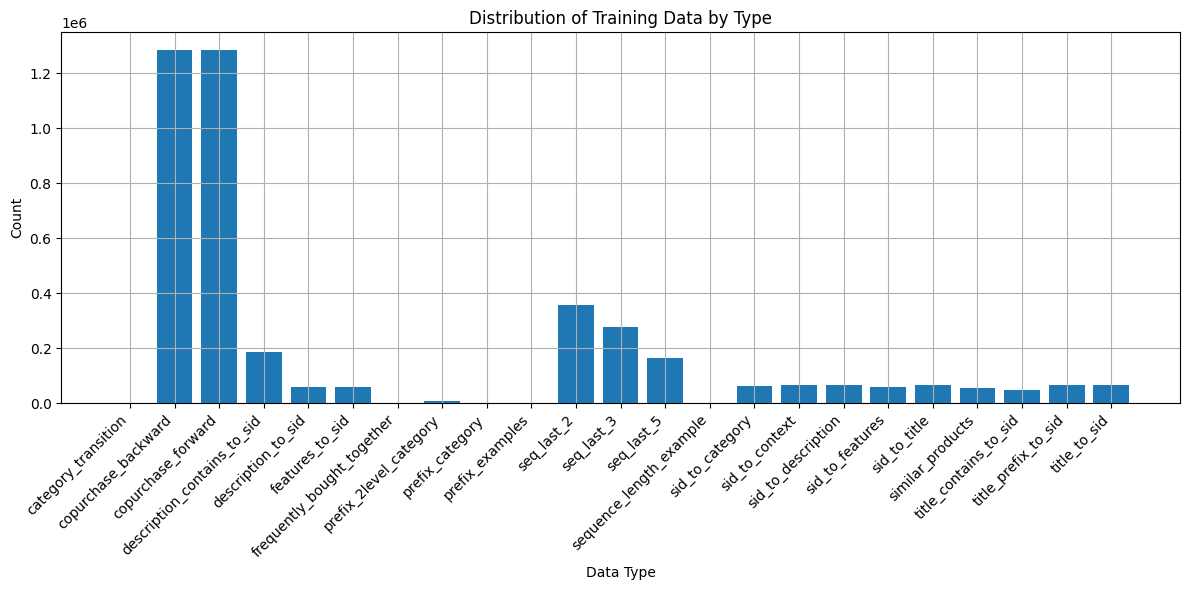

In [26]:
# Create a bar chart of type distribution
plt.figure(figsize=(12, 6))
plt.grid(True)
type_counts = type_stats.sort("type")
plt.bar(type_counts["type"], type_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Data Type")
plt.ylabel("Count")
plt.title("Distribution of Training Data by Type")
plt.tight_layout()
plt.show()

In [27]:
df_samples.head()

conversations,type,user_message,assistant_message,user_message_length,assistant_message_length,user_message_tokens,assistant_message_tokens
list[struct[2]],str,str,str,u32,u32,u32,u32
"[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""A user who bought <sid><SID_15><SID_456><SID_644><SID_768></sid> (BioShock Infinite - PC) might also buy:""}, {""assistant"",""<sid><SID_172><SID_260><SID_714><SID_768></sid>""}]","""copurchase_forward""","""A user who bought <sid><SID_15…","""<sid><SID_172><SID_260><SID_71…",105,47,12,1
"[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Product <sid><SID_160><SID_387><SID_661><SID_768></sid> features:""}, {""assistant"",""Connect a wired Xbox 360 controller to your PlayStation3 console Supports rapid fire function New: Supports rumble The Plus version now supports rumble and is compatible with all PS3 This device must be used with the official 360 WIRED controller""}]","""sid_to_features""","""Product <sid><SID_160><SID_387…","""Connect a wired Xbox 360 contr…",65,246,3,40
"[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Based on recent purchases: <sid><SID_69><SID_285><SID_580><SID_768></sid>, <sid><SID_31><SID_493><SID_518><SID_768></sid>, <sid><SID_58><SID_344><SID_615><SID_772></sid>, next item:""}, {""assistant"",""<sid><SID_40><SID_301><SID_628><SID_768></sid>""}]","""seq_last_3""","""Based on recent purchases: <si…","""<sid><SID_40><SID_301><SID_628…",181,46,9,1
"[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""Before buying <sid><SID_98><SID_440><SID_759><SID_769></sid> (Amazon Basics Dual Charging Station for Xbox One, Xbox One Standard, And Xbox One Elite Controllers - Black), users often buy:""}, {""assistant"",""<sid><SID_179><SID_342><SID_525><SID_768></sid>""}]","""copurchase_backward""","""Before buying <sid><SID_98><SI…","""<sid><SID_179><SID_342><SID_52…",188,47,24,1
"[{""system"",""You are a helpful AI assistant that understands and works with semantic IDs for product recommendations. Semantic IDs are hierarchical identifiers in the format <sid><SID_X><SID_Y><SID_Z><SID_W></sid> that encode product relationships and categories.""}, {""user"",""A user who bought <sid><SID_211><SID_258><SID_586><SID_768></sid> (FIFA Soccer 10 - Playstation 3) might also buy:""}, {""assistant"",""<sid><SID_137><SID_257><SID_589><SID_768></sid>""}]","""copurchase_forward""","""A user who bought <sid><SID_21…","""<sid><SID_137><SID_257><SID_58…",114,47,14,1


In [28]:
# Data type distribution
logger.info("FINAL STATISTICS")
logger.info("=" * 50)

logger.info(f"Total unique samples: {len(df_samples):,}")

# Data type breakdown
type_counts = df_samples.group_by("type").agg(pl.len().alias("count")).sort("type")
logger.info("Data type distribution:")
for row in type_counts.iter_rows(named=True):
    logger.info(f"  {row['type']}: {row['count']:,} samples ({row['count'] / len(df_samples) * 100:.1f}%)")

# Token statistics from DataFrame
logger.info("Token statistics:")
logger.info(f"  Average instruction length: {df_samples['user_message_length'].mean():.1f} tokens")
logger.info(f"  Average output length: {df_samples['assistant_message_length'].mean():.1f} tokens")
logger.info(
    f"  Average total length: {df_samples['user_message_length'].mean() + df_samples['assistant_message_length'].mean():.1f} tokens"
)
logger.info(
    f"  Estimated total tokens: {(df_samples['user_message_length'].sum() + df_samples['assistant_message_length'].sum()):,}"
)

# Sample diversity
unique_instructions = df_samples["user_message"].n_unique()
unique_outputs = df_samples["assistant_message"].n_unique()

logger.info("Diversity metrics:")
logger.info(f"  Unique instructions: {unique_instructions:,} ({unique_instructions / len(df_samples) * 100:.1f}%)")
logger.info(f"  Unique outputs: {unique_outputs:,} ({unique_outputs / len(df_samples) * 100:.1f}%)")

09:19:06 - FINAL STATISTICS
09:19:06 - ==================================================
09:19:06 - Total unique samples: 4,231,525
09:19:06 - Data type distribution:
09:19:06 -   category_transition: 117 samples (0.0%)
09:19:06 -   copurchase_backward: 1,284,784 samples (30.4%)
09:19:06 -   copurchase_forward: 1,284,784 samples (30.4%)
09:19:06 -   description_contains_to_sid: 185,690 samples (4.4%)
09:19:06 -   description_to_sid: 56,791 samples (1.3%)
09:19:06 -   features_to_sid: 57,375 samples (1.4%)
09:19:06 -   frequently_bought_together: 500 samples (0.0%)
09:19:06 -   prefix_2level_category: 7,578 samples (0.2%)
09:19:06 -   prefix_category: 256 samples (0.0%)
09:19:06 -   prefix_examples: 256 samples (0.0%)
09:19:06 -   seq_last_2: 357,229 samples (8.4%)
09:19:06 -   seq_last_3: 278,586 samples (6.6%)
09:19:06 -   seq_last_5: 165,066 samples (3.9%)
09:19:06 -   sequence_length_example: 40 samples (0.0%)
09:19:06 -   sid_to_category: 62,985 samples (1.5%)
09:19:06 -   sid_to_